------------------------------------------------------------------
# IMPORT LIBRARIES
------------------------------------------------------------------

In [1]:
# import standard libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
import keras
# tf.enable_eager_execution() #N.B. enabling this causes conflicts with cp_callback and tf.argmax

#import plotting libraries
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import file handler libraries
!pip install -U -q PyDrive
import sys, os, shutil, zipfile,glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.metrics import confusion_matrix, accuracy_score,roc_curve, auc,roc_auc_score,classification_report

#clear existing files
!rm -rf /content/training
!rm -rf /content/data_train

# Authenticate and create the drive client for saving your model.
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!ls '/content/gdrive/My Drive/Models'

#create directory to store training data
if not os.path.exists('training'): 
    os.makedirs('training')
    print('Created training directory')
    
# Authenticate and create the PyDrive client for loading training data.
auth.authenticate_user() 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



Using TensorFlow backend.


Mounted at /content/gdrive
emonpi
Created training directory


------------------------------------------------------------------
# LINK DATA TO INSTANCE
------------------------------------------------------------------

In [2]:
#grab this zip id from the suffix of your google drive zip file sharing link
zip_id = '1ShWZ4olv0SdT6jpRbVgF2C7q0tZZVKYc' #FILE ID CREATED FROM SHARING URL (ID=....)

# DOWNLOAD TRAINING DATA ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('data_train.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('data_train.zip', 'r') #file to be extracted
zip_ref.extractall('./data_train') #where the files are extracted
zip_ref.close()

model_dir_path = '/content/gdrive/My Drive/Models'
# Check that this directory exists.
os.path.isdir(model_dir_path)

# Make a new directory for our model
example_path = os.path.join(model_dir_path, 'emonpi')
print('\nexample_path',example_path)

if not os.path.isdir(example_path):
  os.makedirs(example_path)
  print('example path created')

checkpoint_path = os.path.join(example_path, 'wb_model_2.h5')
print('\ncheckpoint_path',checkpoint_path)
# Create a keras callback that saves our model during training.
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path)

Uncompressing zip file

example_path /content/gdrive/My Drive/Models/emonpi

checkpoint_path /content/gdrive/My Drive/Models/emonpi/wb_model_2.h5


------------------------------------------------------------------
# LOAD AND PREPROCESS DATA
------------------------------------------------------------------

In [3]:
# Define path to training data directory
training_path = '/content/data_train/data_train/'
print('Finished unzipping, contents:',os.listdir(training_path))

data_path = training_path 

# Function to parse through training data, reshape and append to a list of samples
# params: filepath - path to training data, labels - optional list of labels, optional list of training data
# returns: labels - list of sample labels, data - list of reshaped data samples
def build_dataset(filepath,labels=[],data=[]):
    vars = ['time', 'power_factor', 'phase_angle', 'power_real', 'power_reactive', 'power_apparent', 'vrms', 'irms']
    cwd = os.chdir(filepath)
    for appliance_type in os.listdir(cwd):
        if appliance_type.endswith('.csv'):
            label = appliance_type.split("_")[0] #label is in title, before "_"
            labels.append(label)
            app_arr = np.genfromtxt(appliance_type, delimiter=',')
            data.append(np.array(app_arr))
    return labels,data
  
# extracts CSV into labels & data
dataset_labels_str,dataset_data = build_dataset(data_path) 

# convert to numpy array
dataset_data_np = np.asarray(dataset_data) 

#let's make sure everything is shipshape
print("dataset_data shape: ",dataset_data_np.shape)


Finished unzipping, contents: ['cell_28.csv', 'sadlamp_50.csv', 'cell_12.csv', 'kettle_19.csv', 'laptop_72.csv', 'monitor_97.csv', 'desklamp_28.csv', 'laptop_74.csv', 'monitor_17.csv', 'fan_1.csv', 'none_97.csv', 'laptop_39.csv', 'cell_53.csv', 'monitor_35.csv', 'monitor_40.csv', 'sadlamp_47.csv', 'kettle_71.csv', 'kettle_48.csv', 'desklamp_89.csv', 'fan_73.csv', 'laptop_55.csv', 'none_15.csv', 'cell_84.csv', 'fan_4.csv', 'sadlamp_4.csv', 'kettle_53.csv', 'sadlamp_6.csv', 'laptop_26.csv', 'monitor_13.csv', 'laptop_20.csv', 'sadlamp_55.csv', 'monitor_5.csv', 'fan_56.csv', 'none_3.csv', 'none_68.csv', 'sadlamp_81.csv', 'desklamp_8.csv', 'sadlamp_35.csv', 'sadlamp_11.csv', 'none_21.csv', 'desklamp_58.csv', 'kettle_95.csv', 'cell_36.csv', 'laptop_90.csv', 'cell_76.csv', 'laptop_11.csv', 'desklamp_98.csv', 'monitor_76.csv', 'monitor_41.csv', 'cell_86.csv', 'monitor_94.csv', 'desklamp_18.csv', 'laptop_92.csv', 'monitor_36.csv', 'kettle_55.csv', 'desklamp_36.csv', 'laptop_22.csv', 'desklamp_9

In [4]:
#--------------------PREPROCESSING & LABEL ENCODING--------------------

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))  # define range for scale operation

# Iterate through dataset and normalize each data sample
scaled_dataset = []
for i,sample in enumerate(dataset_data_np):
  app_arr_normalized = min_max_scaler.fit_transform(np.array(sample)) #must scale when in 2D array form
  scaled_dataset.append(app_arr_normalized)
  
# Convert normalized dataset to numpy
scaled_dataset = np.array(scaled_dataset)
print("scaled_dataset.shape: ",scaled_dataset.shape)

# Create label encoding for converting from string labels to integer
le = preprocessing.LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# Fit label encoding to sample labels
le.fit(dataset_labels_str)
key = list(le.classes_)

# Apply label encoding to labels
dataset_labels_int = le.transform(dataset_labels_str)
print(dataset_labels_int[:15])
print(dataset_labels_str[:15])


# Create dictionary of label encoding
encoding = {}
print('key:',key)
for i in key:
  translate = le.transform([i])
  encoding[int(translate)] = str(i)

print("\nappliance_dict = ",encoding)


scaled_dataset.shape:  (800, 40, 8)
[0 7 0 3 4 5 1 4 5 2 6 4 0 5 5]
['cell', 'sadlamp', 'cell', 'kettle', 'laptop', 'monitor', 'desklamp', 'laptop', 'monitor', 'fan', 'none', 'laptop', 'cell', 'monitor', 'monitor']
key: ['cell', 'desklamp', 'fan', 'kettle', 'laptop', 'monitor', 'none', 'sadlamp']

appliance_dict =  {0: 'cell', 1: 'desklamp', 2: 'fan', 3: 'kettle', 4: 'laptop', 5: 'monitor', 6: 'none', 7: 'sadlamp'}


In [5]:
##converts to H,W,D from H,W because tensorflow works best with image formats (R,G,B)
def make3D(array,n): #adds channels to array to simulate an image
  reshape = np.stack((array,)*n, axis=-1)
#   print("array.shape",array.shape,"reshape.shape",reshape.shape)
  return (np.stack((array,)*n, axis=-1))

# Transform samples to be 3D for use in NN models
dataset3D = []
for i,sample in enumerate(scaled_dataset):
  dim3 = make3D(np.array(sample),3) #must scale when in 2D array form
  dataset3D.append(dim3)
  
dataset3D = np.array(dataset3D)
print('dataset before reshaping:',scaled_dataset.shape,'...reshaped to 3d array:',dataset3D.shape,'...individual array: ',dataset3D[0].shape)

dataset before reshaping: (800, 40, 8) ...reshaped to 3d array: (800, 40, 8, 3) ...individual array:  (40, 8, 3)


In [6]:
# # -- Split data into training and test subsets
data_train, data_test, labels_train, labels_test = train_test_split(dataset3D, dataset_labels_int, test_size=0.30)#, random_state=42) #initialize random_state to get same result every time
print('Train data shape:',data_train.shape,'...# of train labels:',len(labels_train),'... unique train labels:',set(labels_train))
print('Test data shape:',data_test.shape,'...# of test labels:',len(labels_test),'... unique test labels:',set(labels_test))

num_labels = len(set(labels_train))
print(num_labels,'unique labels created')


Train data shape: (560, 40, 8, 3) ...# of train labels: 560 ... unique train labels: {0, 1, 2, 3, 4, 5, 6, 7}
Test data shape: (240, 40, 8, 3) ...# of test labels: 240 ... unique test labels: {0, 1, 2, 3, 4, 5, 6, 7}
8 unique labels created


In [0]:
# Convert data to float32 datatype and labels to int64 datatype.
train_data = tf.cast(data_train, tf.float32)
train_labels = tf.cast(labels_train, tf.int64)
test_data = tf.cast(data_test, tf.float32)
test_labels = tf.cast(labels_test, tf.int64)

# ready to create tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# shuffle our training data and batch it so its more efficient.
train_dataset = train_dataset.shuffle(20).batch(50)
test_dataset = test_dataset.shuffle(20).batch(50)

# # # -- Reshape train data for use in model
# # nsamples, nx, ny,_ = data_train.shape
# # train_data_2d = data_train.reshape((nsamples,nx*ny))

# # # -- Reshape test data for use in model
# # nsamples, nx, ny,_  = data_test.shape
# # test_data_2d = data_test.reshape((nsamples,nx*ny))

------------------------------------------------------------------
# BASELINE NEURAL NETWORK MODEL 
-----------------------------------------------------------------

In [8]:
model = tf.keras.Sequential() 
model.add(tf.keras.layers.Flatten(input_shape=[40,8,3]))
model.add(tf.keras.layers.Dense(num_labels*16, activation='relu'))
model.add(tf.keras.layers.Dense(num_labels, activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy','sparse_categorical_crossentropy'])

model.summary()
print("\n\n")
# Train the model, keras does not need datasets to function, can just take raw numpy 
history = model.fit(data_train, 
                    labels_train, 
                    epochs=20,
                    batch_size=10,
                    validation_data=(data_test,labels_test),
                    callbacks=[cp_callback])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               123008    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 124,040
Trainable params: 124,040
Non-trainable params: 0
_________________________________________________________________



Train on 560 samples, validate on 240 samples
Epoch 1/20
560/560 [==============================] - 1s 2ms/sample - loss: 1.0244 - acc: 0.7036 - sparse_categorical_crossentropy: 1.0244 - val_loss: 0.4520 - val_acc: 0.8708 - val_sparse_categorical_crossentropy: 0.4520
Epoch 2/20
560/560 [==============================] - 0s 

------------------------------------------------------------------
# DATA AUGMENTED MODEL
-----------------------------------------------------------------

In [9]:
from random import randint
import cv2

def warp_shrink(feat):
    """
    Takes in a feature in the form of a numpy array, takes a random sample from the array and shrinks it by half.
    The size of the random sample is equal to 1/10 of the size of the source array.  Replaces sample with pair-wise average of sample indices.
    Approach inspired from this paper: https://aaltd16.irisa.fr/files/2016/08/AALTD16_paper_9.pdf
    Parameters: feat - feature to be warped in form of numpy array
    Returns: Feature array with sample shrank
    """
    sample_range = feat.shape[0]

    #Calculate length of sample
    sample_tenth = int(int(sample_range)*.1)

    #Shift sample length to be even to allow for pair-wise averages
    if sample_tenth % 2 == 1:
        sample_tenth += 1

    # Generate random index for start of sample
    sample_index = randint(0, sample_range - (sample_tenth))

    #Shift sample index to be even to allow for pair-wise averages
    if sample_index % 2 == 1:
        sample_index += 1

    #Subset feature array into sample
    sample = feat[sample_index:int(sample_index+sample_tenth)]

    avg_arr = []
    for i in range(0, sample_tenth, 2): #iterate thru pairs of elements in sample, calculating average
        avg = (sample[i]+sample[i+1])/2
        avg_arr.append(avg)

    avg_arr = np.array(avg_arr)

    # Replace sample with shrunk average of samples
    feat_before = feat[:sample_index]
    feat_after = feat[int(sample_index+sample_tenth):]
    feat_transformed = np.concatenate([feat_before,avg_arr,feat_after])

    return feat_transformed 
  
def warp_stretch(feat):
    """
    Takes in a feature in the form of a numpy array, takes a random sample from the array and shrinks it by half.
    The size of the random sample is equal to 1/10 of the size of the source array.  Appends pair-wise average of every other sample index.
    Approach inspired from this paper: https://aaltd16.irisa.fr/files/2016/08/AALTD16_paper_9.pdf
    Parameters: feat - feature to be warped in form of numpy array
    Returns: Feature array with sample stretched
    """

    sample_range = feat.shape[0]

    # Calculate length of sample
    sample_tenth = int(int(sample_range)*.1)

    # Shift sample length to be even to allow for pair-wise averages
    if sample_tenth % 2 == 1:
        sample_tenth += 1

    # Generate random index for start of sample
    sample_index = randint(0, sample_range - (sample_tenth))

    # Shift sample index to be even to allow for pair-wise averages
    if sample_index % 2 == 1:
        sample_index += 1

    # Subset feature array into sample
    sample = feat[sample_index:int(sample_index + sample_tenth)]

    stretch_arr = []
    for i in range(0, sample_tenth,2): #Iterate thru each pair of elements in the sample
        if (i > 0 & i <= sample_tenth-1):  #Get average of previous index and current index
            avg_prev = (sample[i-1]+sample[i])/2
            stretch_arr.append(avg_prev)
        avg = (sample[i]+sample[i+1])/2 #Get average of current index
        stretch_arr.append(sample[i])
        stretch_arr.append(avg)
        stretch_arr.append(sample[i+1])

    stretch_arr = np.array(stretch_arr)

    #Replace sample with stretched sample
    feat_before = feat[:sample_index]
    feat_after = feat[int(sample_index+sample_tenth):]
    feat_transformed = np.concatenate([feat_before,stretch_arr,feat_after])

    return feat_transformed 


def warp_features(observation):
    """"
    Applies warp shrink/stretch at random to numpy array of feature arrays.
    Parameters: observation - numpy array of arrays
    Returns: warped numpy array of arrays
    """
    new_obs = []
    observation_reshape,g,r = cv2.split(observation) #splitting into single channel and back again

    for feature in range(0,observation_reshape.shape[0]): #Iterates thru each feature array       
        observation_feature = observation_reshape[feature]
        if (randint(0,1) > 0):
            warped_feature = warp_stretch(observation_feature) # applies stretch randomly
        else:
            warped_feature = warp_shrink(observation_feature) # else applies shrink
        new_obs.append(warped_feature)

    np_array = np.asarray(new_obs)

    for i,j in enumerate(np_array):
      diff_list = []
      for k,l in enumerate(j):
        diff_list.append(l-observation_reshape[i][k])
    array_3D = make3D(np_array,3)

    return array_3D 

#test the warp/shrink outputs the right shapes
warped_data = warp_features(data_train[0])
print("observation.shape",data_train[0].shape, "warped_data.shape",warped_data.shape)


observation.shape (40, 8, 3) warped_data.shape (40, 8, 3)


In [10]:
# #DATA AUGMENTATION

# preprocessing_function: function that will be implied on each input. 
#   The function will run after the image is resized and augmented. 
#   The function should take one argument: one image (Numpy tensor with rank 3), 
#     and should output a Numpy tensor with the same shape.

def apply_noise(array):#preprocessing_function...apply gaussian noise
  return array #+ noise
  
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=apply_noise)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=warp_features)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

labels_train_np_1d = make3D(np.array(labels_train),1) #must have an additional channel for generator function
labels_test_np_1d = make3D(np.array(labels_test),1) #must have an additional channel for generator function

print('train:',data_train.shape,type(data_train),'labels:',labels_train_np_1d.shape,type(labels_train_np_1d))
print('test:',data_test.shape,type(data_test),'labels:',labels_test_np_1d.shape,type(labels_test_np_1d))

train_generator = train_datagen.flow(
#     train_data, #tensor w/ added axis #TypeError: unsupported operand type(s) for /: 'Dimension' and 'int'
#     train_dataset, #(Tensor dataset input): TypeError: object of type 'DatasetV1Adapter' has no len()
#     data_train, #(NP input) ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (144, 50, 8))
    data_train, #(NP input) ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (144, 50, 8))
    labels_train_np_1d,
#     train_labels,
# dataset_data_np, #ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (161, 50, 8))
#       dataset_labels_int,
    batch_size=10)

test_generator = test_datagen.flow(
    data_test, #(NP input required)
    labels_test_np_1d,
    batch_size=10)

train: (560, 40, 8, 3) <class 'numpy.ndarray'> labels: (560, 1) <class 'numpy.ndarray'>
test: (240, 40, 8, 3) <class 'numpy.ndarray'> labels: (240, 1) <class 'numpy.ndarray'>


In [11]:
aug_model = tf.keras.Sequential() # Use keras sequential layers to build up a model.
# aug_model.add(tf.keras.layers.Flatten(input_shape=[50,8]))
aug_model.add(tf.keras.layers.Flatten(input_shape=[40,8,3]))
aug_model.add(tf.keras.layers.Dense(num_labels*16, activation='relu'))
aug_model.add(tf.keras.layers.Dense(num_labels, activation='softmax'))

aug_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy','sparse_categorical_crossentropy'])
aug_model.summary()

print('--------------------------SHAPES--------------------------')
print("\n\n")
print('train:',data_train.shape,type(data_train),'labels:',labels_train_np_1d.shape,type(labels_train_np_1d))
print('test:',data_test.shape,type(data_test),'labels:',labels_test_np_1d.shape,type(labels_test_np_1d))
print("\n\n")

aug_history = aug_model.fit_generator(train_generator, validation_data=test_generator, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               123008    
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
Total params: 124,040
Trainable params: 124,040
Non-trainable params: 0
_________________________________________________________________
--------------------------SHAPES--------------------------



train: (560, 40, 8, 3) <class 'numpy.ndarray'> labels: (560, 1) <class 'numpy.ndarray'>
test: (240, 40, 8, 3) <class 'numpy.ndarray'> labels: (240, 1) <class 'numpy.ndarray'>



Epoch 1/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0319 - acc: 0.6732 - sparse_categorical_crossentropy: 1.0319 - val_loss: 0.4104 - val

------------------------------------------------------------------
# MORE COMPLEX MODEL
-----------------------------------------------------------------

In [12]:
complex_model = tf.keras.Sequential()
complex_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=[40,8,3]))
complex_model.add(tf.keras.layers.BatchNormalization())
complex_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
complex_model.add(tf.keras.layers.Dropout(0.3))
complex_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
complex_model.add(tf.keras.layers.BatchNormalization())
complex_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
complex_model.add(tf.keras.layers.Dropout(0.3))
complex_model.add(tf.keras.layers.Flatten())
complex_model.add(tf.keras.layers.Dense(64, activation='relu'))
complex_model.add(tf.keras.layers.BatchNormalization())
complex_model.add(tf.keras.layers.Dropout(0.5))
complex_model.add(tf.keras.layers.Dense(num_labels, activation='softmax'))
complex_model.add(tf.keras.layers.BatchNormalization())
complex_model.add(tf.keras.layers.Activation('softmax'))

complex_model.summary()
print("\n\n")

complex_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy','sparse_categorical_crossentropy'])

complex_history = model.fit(data_train, labels_train, epochs=20,batch_size=10,validation_data=(data_test,labels_test))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 8, 64)         832       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 40, 8, 64)         256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 4, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 4, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 4, 32)         8224      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 20, 4, 32)         128       
___________________________

------------------------------------------------------------------
# MODEL COMPARISON
-----------------------------------------------------------------

In [0]:
def plot_history(histories, key='sparse_categorical_crossentropy'):
  
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],'--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),label=name.title()+' Train')
  plt.title(key)
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

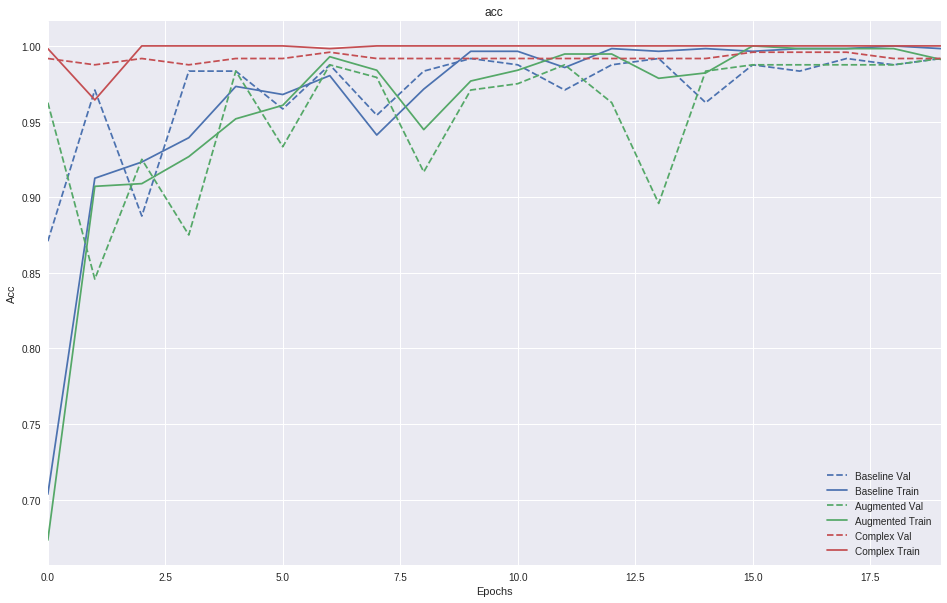

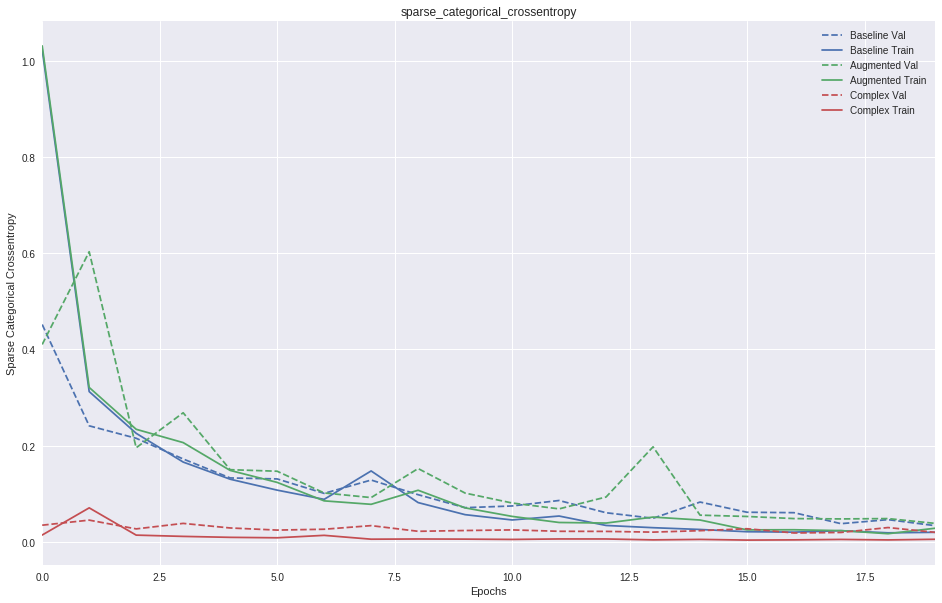

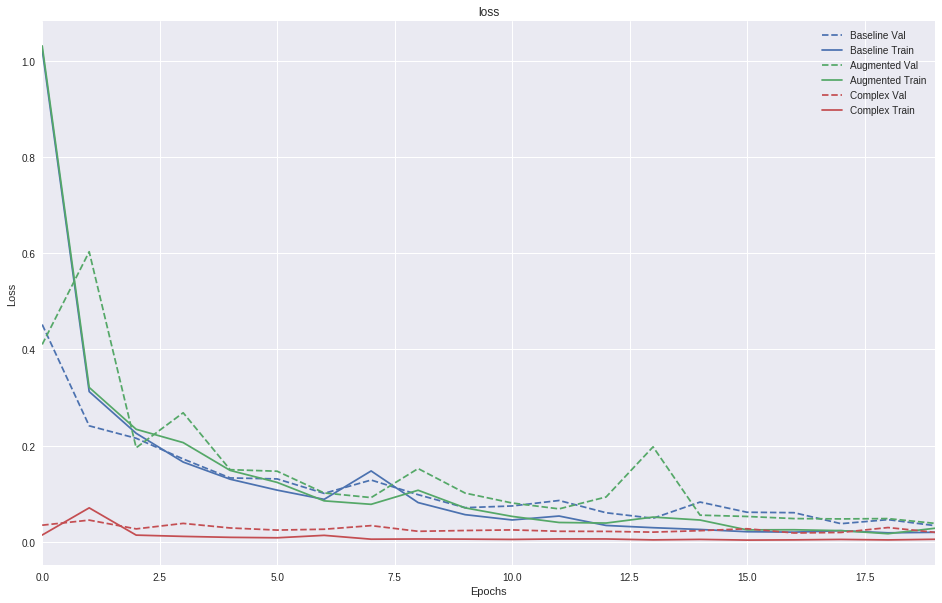

In [14]:
plot_history([('baseline', history),('augmented', aug_history),('complex', complex_history)], key='acc')
plot_history([('baseline', history),('augmented', aug_history),('complex', complex_history)], key='sparse_categorical_crossentropy')
plot_history([('baseline', history),('augmented', aug_history),('complex', complex_history)], key='loss')

## **Copy This To Your Classification Python Script:**

In [15]:
print('appliance_dict = ',encoding)

appliance_dict =  {0: 'cell', 1: 'desklamp', 2: 'fan', 3: 'kettle', 4: 'laptop', 5: 'monitor', 6: 'none', 7: 'sadlamp'}


------------------------------------------------------------------
# VALIDATION
-----------------------------------------------------------------

In [16]:
#Let's see what we get 
for i,data in enumerate(data_test[:10]): #a sample
  data = data[tf.newaxis, ...]
  guess_list = model.predict(data)
  print('Index:',i,'...  Actual:',labels_test[i],encoding.get(labels_test[i]),'... Guess:',np.argmax(guess_list),encoding.get(np.argmax(guess_list)))
  print('')

Index: 0 ...  Actual: 4 laptop ... Guess: 4 laptop

Index: 1 ...  Actual: 0 cell ... Guess: 4 laptop

Index: 2 ...  Actual: 0 cell ... Guess: 0 cell

Index: 3 ...  Actual: 7 sadlamp ... Guess: 7 sadlamp

Index: 4 ...  Actual: 7 sadlamp ... Guess: 7 sadlamp

Index: 5 ...  Actual: 3 kettle ... Guess: 3 kettle

Index: 6 ...  Actual: 4 laptop ... Guess: 4 laptop

Index: 7 ...  Actual: 4 laptop ... Guess: 4 laptop

Index: 8 ...  Actual: 7 sadlamp ... Guess: 7 sadlamp

Index: 9 ...  Actual: 2 fan ... Guess: 2 fan



In [17]:
# Let’s go ahead and load the model, this would be what we do when starting a new notebook.
model = tf.keras.models.load_model(checkpoint_path)
model.evaluate(data_test, labels_test) # Evaluate to make sure the accuracy is preserved.

240/240 [==============================] - 0s 363us/sample - loss: 0.0332 - acc: 0.9917 - sparse_categorical_crossentropy: 0.0332


[0.033163868139187494, 0.9916667, 0.033163868]

#Confusion Matrix

In [18]:
#build label list for confusion matrix
predictions = model.predict(data_test)

pred_index = []
for i,data in enumerate(predictions):
  pred_index.append(np.argmax(data))
  
encoding_list = list(set(labels_train))
print('encoding list:',encoding_list)

label_list = [] 
for i in encoding_list:
  label_list.append(encoding.get(i))
  
print('label_list:', label_list)

encoding list: [0, 1, 2, 3, 4, 5, 6, 7]
label_list: ['cell', 'desklamp', 'fan', 'kettle', 'laptop', 'monitor', 'none', 'sadlamp']


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


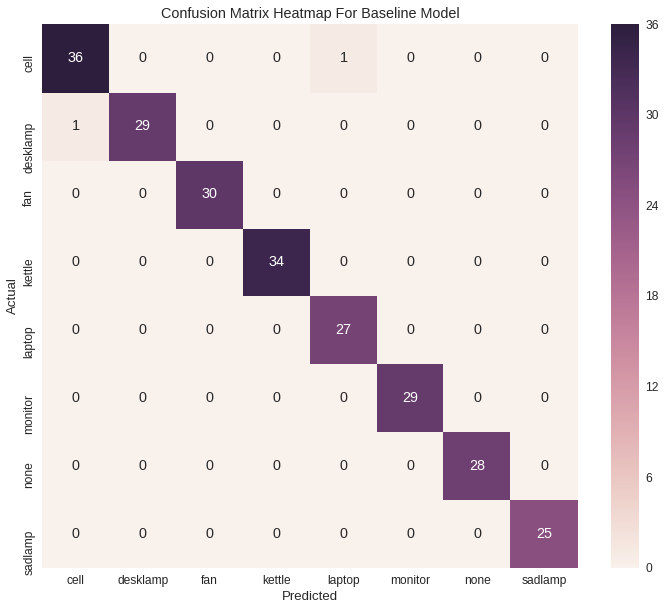

In [19]:
#confusion matrix
conf = tf.math.confusion_matrix(
        labels_test,
        pred_index,
        num_classes=None,
        dtype=tf.dtypes.int32,
        name=None,
        weights=None)

#heatmaps don't play well with tensor objects, must convert to np array
sess = tf.Session() 
with sess.as_default():
  conf_np = conf.eval()
  
#heat map plotting
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_np, annot=True, fmt='d',
            xticklabels=label_list,
             yticklabels=label_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_title('Confusion Matrix Heatmap For Baseline Model')
plt.show()